In [1]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.3 MB/s eta 0:00:00:00:010:01m
  Attempting uninstall: nv

In [2]:
# from mamba_ssm.ops.selective_scan_interface import selective_scan_fn, selective_scan_ref

import os
import glob
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics import Accuracy, JaccardIndex
from tqdm import tqdm


# Cấu hình OpenCV để tránh xung đột
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

# Định nghĩa các hằng số
CLASSES = ["Noise", "LTE", "NR", "Radar"]
COLORMAP = [[0, 0, 0], [80, 80, 80], [160, 160, 160], [255, 255, 255]]

# data

In [3]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])



# Định nghĩa Dataset
class SearchDataset(Dataset):
    def __init__(self, root="/kaggle/input/IRecSpecUNet", image_set="train", download=True, transform=None):
        self.images = sorted(glob.glob(os.path.join(root, image_set, 'input', '*.png')))
        self.masks = sorted(glob.glob(os.path.join(root, image_set, 'label', '*.png')))
        self.transform = transform
        self.classes = len(COLORMAP)  # Số lớp (4 trong trường hợp này)

    def __len__(self):
        return len(self.images)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # Chuyển mask RGB thành nhãn lớp đơn kênh
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width), dtype=np.uint8)  # Chỉ cần 1 kênh cho nhãn lớp
        for label_index, label_color in enumerate(COLORMAP):
            segmentation_mask[np.all(mask == label_color, axis=-1)] = label_index
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)  # Giờ mask là 2D với nhãn lớp

        if self.transform is not None:
            image = self.transform(image) 
            mask = torch.from_numpy(mask).long()  # Chuyển mask thành tensor long

        return image, mask

# Tạo dataset và dataloader
train_dataset = SearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = SearchDataset(image_set="val", download=False, transform=train_transform)

# Cấu hình dataloader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 32
n_workers = os.cpu_count()

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

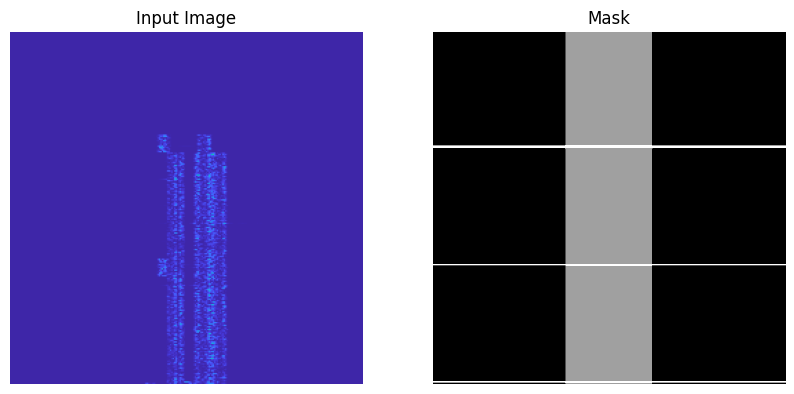

In [4]:
import matplotlib.pyplot as plt

# Lấy ảnh đầu tiên từ tập test
test_dataset = SearchDataset(image_set="val", download=False, transform=None)  # Không áp dụng transform để lấy ảnh gốc
image, mask = test_dataset[0]

# Chuyển đổi tensor hoặc numpy array về định dạng phù hợp để hiển thị
image = image.numpy().transpose(1, 2, 0) if isinstance(image, torch.Tensor) else image  # Nếu ảnh là tensor, chuyển về numpy
mask = mask.numpy() if isinstance(mask, torch.Tensor) else mask  # Chuyển mask về numpy nếu cần

# Tạo colormap cho mask dựa trên COLORMAP
from matplotlib.colors import ListedColormap
cmap = ListedColormap(np.array(COLORMAP) / 255.0)  # Chuẩn hóa COLORMAP về [0, 1]

# Hiển thị ảnh và mask
plt.figure(figsize=(10, 5))

# Hiển thị ảnh gốc
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image)
plt.axis('off')

# Hiển thị mask
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap=cmap, vmin=0, vmax=len(COLORMAP)-1)
plt.axis('off')

plt.show()

# model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OFAGConv(nn.Module):  # 3x1
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, ofag=8, use_relu=True):
        super().__init__()
        self.g = ofag
        self.c_ = c2 // self.g
        self.use_relu = use_relu

        # --- Xử lý kernel size và stride ---
        self.k = k if isinstance(k, tuple) else (k, k)
        kh, kw = self.k
        self.s = s if isinstance(s, tuple) else (s, s)

        # --- Tính padding nếu không được cung cấp ---
        if p is None:
            ph = (kh - 1) // 2
            pw = (kw - 1) // 2
            p = (ph, pw)
        self.p = p

        # --- Convolution cơ bản ---
        self.conv = nn.Conv2d(
            c1 // self.g, self.c_,
            kernel_size=self.k, stride=self.s,
            padding=self.p, groups=g, dilation=d, bias=False
        )

        # --- BatchNorm + ReLU ---
        if self.use_relu:
            self.bn_silu = nn.Sequential(
                nn.BatchNorm2d(c2),
                nn.ReLU(inplace=True)
            )
        else:
            self.bn_silu = nn.BatchNorm2d(c2)

        # --- Tham số scale riêng cho từng group (kể cả group 0) ---
        self.trainable_scale_cc = nn.ParameterList([
            nn.Parameter(torch.ones(c1 // self.g, 1, 1)) for _ in range(self.g)
        ])
        self.trainable_scale_sc = nn.ParameterList([
            nn.Parameter(torch.ones(1, kh, kw)) for _ in range(self.g)
        ])

        # --- Kernel lưu lại (nếu cần dùng sau này) ---
        self.saved_kernel = None

    def forward(self, x):
        chunks = torch.chunk(x, self.g, dim=1)
        processed_chunks = []

        for i, c in enumerate(chunks):
            weight = self.conv.weight

            # scale cho mọi group, kể cả group 0
            scale_cc = self.trainable_scale_cc[i]
            scale_sc = self.trainable_scale_sc[i]
            weight = weight * scale_cc * scale_sc

            # dùng cùng 1 self.conv cho mọi chunk
            out = F.conv2d(c, weight, padding=self.p, stride=self.s)
            # out = self.bn_silu(out)
            processed_chunks.append(out)

        return self.bn_silu(torch.cat(processed_chunks, dim=1))

class OFABasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=1, downsample=None):
        super().__init__()
        self.ofag=groups
        self.ofaconv1 = OFAGConv(c1=in_channels, c2=out_channels, k=(3,3), s=stride, ofag=8, use_relu=True)
        self.ofaconv2 = OFAGConv(c1=out_channels, c2=out_channels, k=(3,3), s=1, ofag=8, use_relu=False)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        # self.ca = SA(out_channels)

    def forward(self, x):
        identity = x
        out = self.ofaconv1(x)
        out = self.ofaconv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
        # return self.ca(out)
# ======== BasicBlock ========
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=1, downsample=None):
        super().__init__()
        self.groups = groups
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False, groups=groups)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False, groups=groups)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        # self.ca = SA(out_channels)
        

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
        # return self.ca(out)


# ======== ResNetEncoder ========
class ResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.gshallow = 1
        self.gdeep = 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1, groups=self.gshallow)
        self.layer2 = self._make_ofa_layer(64, 128, blocks=2, stride=2, groups=self.gshallow)
        # self.layer3 = self._make_layer(128, 256, blocks=2, stride=2, groups=self.gdeep)
        # self.layer4 = self._make_layer(256, 512, blocks=2, stride=2, groups=self.gdeep)
        self.layer3 = self._make_ofa_layer(128, 256, blocks=2, stride=2, groups=self.gdeep)
        self.layer4 = self._make_ofa_layer(256, 512, blocks=2, stride=2, groups=self.gdeep)

    def _make_layer(self, in_channels, out_channels, blocks, stride, groups):
        downsample = None
        if stride != 1 or in_channels != out_channels: #res identity
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [BasicBlock(in_channels, out_channels, stride, groups, downsample)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
        
    def _make_ofa_layer(self, in_channels, out_channels, blocks, stride, groups):
        downsample = None
        if stride != 1 or in_channels != out_channels: #res identity
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [OFABasicBlock(in_channels, out_channels, stride, groups, downsample)]
        for _ in range(1, blocks):
            layers.append(OFABasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x0 = self.relu(self.bn1(self.conv1(x)))  # [B, 64, H/2, W/2]
        x1 = self.maxpool(x0)                   # [B, 64, H/4, W/4]
        x2 = self.layer1(x1)                    # [B, 64, H/4, W/4]
        x3 = self.layer2(x2)                    # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)                    # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)                    # [B, 512, H/32, W/32]
        return [x0, x2, x3, x4, x5]

# ======== DecoderBlock ========
class Conv2dReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, groups):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False, groups= groups),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.attention = nn.Identity()
    def forward(self, x):
        return self.attention(x)


class GlobalBranch(nn.Module):
    def __init__(self, e_lambda=1e-4):
        super(GlobalBranch, self).__init__()
        self.activaton = nn.Sigmoid()
        self.e_lambda = e_lambda
        # self.conv_1x1 = nn.Conv2d(2, 1, kernel_size=1, bias=False)
        # self.bn = nn.BatchNorm2d(1)
    def forward(self, x):
        # 1. Lấy kích thước (b, c, h, w)
        # x=self.bn(self.conv_1x1(x))
        b, c, h, w = x.size()
        # 2. Tính số lượng phần tử không gian (n = H * W - 1)
        # Trừ 1 để dùng cho công thức phương sai mẫu (Unbiased Sample Variance)
        n = w * h - 1
        # 3. Tính (x - mu)^2
        # keepdim=True giúp giữ nguyên chiều (b, c, 1, 1) để broadcast chính xác khi trừ
        x_minus_mu_square = (x - x.mean(dim=[2, 3], keepdim=True)).pow(2)
        # 4. Tính phương sai của kênh (Channel Variance)
        # v = sum((x - mu)^2) / n
        y = x_minus_mu_square / (4 * (x_minus_mu_square.sum(dim=[2, 3], keepdim=True) / n + self.e_lambda)) + 0.5
        # 5. Áp dụng Sigmoid và nhân với input gốc
        return x * self.activaton(y) 

class DCA(nn.Module):
    """Spatial-attention module."""
    def __init__(self, channel=4):
        super().__init__()
        # assert len(kernel_sizes) >= 2, "cần ít nhất 2 kernel sizes"
        # branch từ (avg,max) concat -> conv3x3, conv7x7 (2->1)
        self.conv_large = GlobalBranch(1e-4)
        # self.bn = nn.BatchNorm2d(1)
        self.conv_small = nn.Conv2d(channel, channel, kernel_size=3,
                                    padding=(3//2), bias=False)


    def forward(self, x):
        """
        x: [B, C, H, W]
        returns: [B, C, H, W] (recalibrated features)
        """
        out = self.conv_large(x) + self.conv_small(x)
        return x

class HAF(nn.Module):
    def __init__(self, in_channels=128, num_classes=4):
        super().__init__()
        # Sửa lỗi: Giả định class SA đã định nghĩa, cần gọi self.sa thay vì self.SA (nếu tên biến là sa)
        self.sa = DCA(num_classes) 
        # self.drop = nn.Dropout(0.1)
        self.conv_out = nn.Conv2d(in_channels, num_classes, kernel_size=1, dilation=1, stride=1, padding=0, bias=False)

    def forward(self, x, h, w):
        # Sửa lỗi: gọi self.sa (instance) chứ không phải self.SA (class)
        x = self.conv_out(x)
        # x = self.drop(x)
        # Upsample về kích thước target (h, w) để tính loss hoặc cộng gộp
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)
        x = self.sa(x) 
        return x

class UnetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups, num_classes=4, aux=False):
        super().__init__()
        self.aux=aux
        self.conv1 = Conv2dReLU(in_channels, out_channels, groups)
        self.attention1 = Attention()
        self.conv2 = Conv2dReLU(out_channels, out_channels, groups)
        self.attention2 = Attention()
        # Khởi tạo layer LSM một lần duy nhất ở đây
        self.haf = HAF(out_channels, num_classes)
        

    def forward(self, x, skip=None, target_size=(256, 256)):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.attention1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        
        # LOGIC QUAN TRỌNG: Chỉ chạy nhánh aux khi đang training
        aux_output = None
        if self.training and self.aux:
            # Dùng self.haf đã init, truyền vào kích thước ảnh mong muốn (ví dụ 256x256)
            aux_output = self.haf(x, target_size[0], target_size[1])
            
        return x, aux_output

class UnetOFADecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups, num_classes=4, aux=False):
        super().__init__()
        self.aux=aux
        self.conv1 = OFAGConv(c1=in_channels, c2=out_channels, k=(3,3), s=1, ofag=8, use_relu=False)
        self.attention1 = Attention()
        self.conv2 = OFAGConv(c1=out_channels, c2=out_channels, k=(3,3), s=1, ofag=8, use_relu=False)
        self.attention2 = Attention()
        # Khởi tạo LSM
        self.haf = HAF(out_channels, num_classes)

    def forward(self, x, skip=None, target_size=(256, 256)):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.attention1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        
        # LOGIC QUAN TRỌNG: Chỉ chạy nhánh aux khi đang training
        aux_output = None
        if self.training and self.aux:
            aux_output = self.haf(x, target_size[0], target_size[1])
            
        return x, aux_output

# ======== UnetDecoder ========
class UnetDecoder(nn.Module):
    # Bỏ tham số 'training' ở init, nn.Module tự quản lý
    def __init__(self, num_classes=4): 
        super().__init__()
        self.center = nn.Identity()
        self.gshallow = 1
        self.gdeep = 1
        self.num_class = num_classes
        # self.gct = GCT(num_classes*3)
        
        # Truyền num_classes vào các block để LSM biết output bao nhiêu lớp
        self.blocks = nn.ModuleList([
            UnetOFADecoderBlock(512 + 256, 256, self.gdeep, num_classes, aux=True),
            UnetOFADecoderBlock(256 + 128, 128, self.gdeep, num_classes, aux=True),
            UnetDecoderBlock(128 + 64, 64, self.gshallow, num_classes, aux=True),
            UnetDecoderBlock(64 + 64, 32, self.gshallow, num_classes, aux=False),
            UnetDecoderBlock(32, 16, self.gshallow, num_classes, aux=False),
        ])

    def forward(self, features):
        x5, x4, x3, x2, x1 = features[::-1]  # reversed for decoder
        x = self.center(x5)
        skips = [x4, x3, x2, x1, None]
        
        haf_outputs = [] # Sửa lỗi chính tả lsm_ouput -> haf_outputs
        
        # Giả sử kích thước ảnh gốc là 256x256, hoặc bạn có thể truyền vào forward
        target_h, target_w = 256, 256 
        
        for block, skip in zip(self.blocks, skips):
            # Truyền target_size vào block để LSM interpolate đúng kích thước
            x, aux = block(x, skip, target_size=(target_h, target_w))
            
            # Chỉ thu thập aux output nếu nó tồn tại (tức là đang training)
            if aux is not None:
                haf_outputs.append(aux)
            
        # Return kết quả
       # --- PHẦN SỬA ĐỔI ---
        if self.training and len(haf_outputs) > 0:

            haf_stack = torch.stack(haf_outputs, dim=0)   # [N_aux, B, C, H, W]
            haf_final = torch.sum(haf_stack, dim=0)       # [B, C, H, W]

            return x, haf_final
            
        else:
            return x, None

# ======== SegmentationHead ========
class SegmentationHead(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.Identity(),
            nn.Identity()  
        )

class OFAUnet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = ResNetEncoder() # Giả định đã có class này
        # Không truyền 'training' vào init của Decoder nữa
        self.decoder = UnetDecoder(num_classes=num_classes)
        self.segmentation_head = SegmentationHead(16, num_classes)

    def forward(self, x):
        # Lấy kích thước ảnh đầu vào để truyền xuống decoder (nếu muốn dynamic size)
        input_size = x.shape[-2:] 
        
        features = self.encoder(x)
        
        # Decoder trả về x và aux_output (có thể là None)
        x_dec, aux_output = self.decoder(features)
        
        # Head chính
        x_out = self.segmentation_head(x_dec)
        
        # Logic Return cuối cùng
        if self.training:
            # Khi train: Trả về cả output chính và aux output
            return x_out, aux_output
        else:
            # Khi inference/eval: Chỉ trả về output chính
            return x_out

model = OFAUnet(4).to(device)
model = nn.DataParallel(model)

# print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Tổng số tham số có thể huấn luyện: {total_params:,}")
print(model)
"""
--OFA-UNet
"""

Tổng số tham số có thể huấn luyện: 765,460
DataParallel(
  (module): OFAUnet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

'\n--OFA-UNet\n'

# train

In [ ]:
Resume_Train = None
import segmentation_models_pytorch as smp

n_eps = 50 # Tổng số epoch muốn train
lr = 1e-3 # Sẽ được dùng bởi optimizer
scheduler_step_size = 20 # Sẽ được dùng bởi scheduler
scheduler_gamma = 0.2 # Sẽ được dùng bởi scheduler
num_classes = 4 # Số lượng lớp của bài toán

criterion_dice = smp.losses.DiceLoss(
    mode='multiclass', 
    from_logits=True
).to(device)
criterion_ce = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
# criterion_dice = DiceLoss(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Giả sử đã định nghĩa ở ngoài
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma) # Giả sử đã định nghĩa

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AverageMeter: # Giữ nguyên AverageMeter cho loss
    def __init__(self): self.reset()
    def reset(self): self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1): self.val = val; self.sum += val * n; self.count += n; self.avg = self.sum / self.count


def evaluate(model, dataloader, criterion_ce, criterion_dice, device, num_classes):
    # [QUAN TRỌNG] Chuyển model sang chế độ đánh giá
    # Lệnh này sẽ set self.training = False trong model
    # => Model sẽ TẮT nhánh aux và chỉ trả về 1 giá trị (main output)
    model.eval() 
    
    test_loss_meter = AverageMeter()
    eval_accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes, average='micro').to(device)
    eval_iou_metric = JaccardIndex(task="multiclass", num_classes=num_classes, average='macro').to(device)

    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Evaluating"):
            x, y = x.to(device), y.to(device)
            
            # Vì đã gọi model.eval(), model chỉ trả về 1 tensor
            y_hat = model(x) 
            loss_d = criterion_dice(y_hat, y)
            loss_c = criterion_ce(y_hat, y)
            loss = loss_d + loss_c
            test_loss_meter.update(loss.item(), n=y.size(0))

            preds = torch.argmax(y_hat, dim=1)
            eval_accuracy_metric.update(preds, y)
            eval_iou_metric.update(preds, y)

    return test_loss_meter.avg, eval_accuracy_metric.compute().item(), eval_iou_metric.compute().item()


# --- Thêm các danh sách để lưu lịch sử metrics ---
train_acc_history = []
train_iou_history = []
test_acc_history = []
test_iou_history = []
# ----------------------------------------------

start_epoch = 1
best_test_mean_iou = 0.0
best_epoch_val = 0

# print("\n" + "="*50)
# print("KIỂM TRA CẤU HÌNH DEPLOY (INFERENCE)")
# model.eval() # Chuyển sang eval: Logic forward sẽ bỏ qua nhánh aux

# # 1. Tổng tham số đang nạp trong RAM (Bao gồm cả Aux chưa cắt bỏ)
# total_params = sum(p.numel() for p in model.parameters())

# # 2. Tính riêng tham số của nhánh Aux (Dựa vào tên biến self.aux_head trong UnetDecoder)
# # Lưu ý: Cần truy cập đúng đường dẫn: model -> decoder -> aux_head
# try:
#     # Nếu model bọc trong DataParallel, cần gọi model.module
#     if isinstance(model, nn.DataParallel) or isinstance(model, nn.parallel.DistributedDataParallel):
#         aux_head_params = sum(p.numel() for p in model.module.decoder.aux_head.parameters())
#     else:
#         aux_head_params = sum(p.numel() for p in model.decoder.aux_head.parameters())
# except AttributeError:
#     aux_head_params = 0
#     print("Warning: Không tìm thấy module 'aux_head' để đếm riêng.")

# # 3. Tham số thực tế (Effective Params) cho Inference
# inference_params = total_params - aux_head_params

# print(f"1. Tổng số tham số trong bộ nhớ (Training build): {total_params:,}")
# print(f"2. Số tham số của nhánh Aux (Chỉ dùng khi Train): {aux_head_params:,}")
# print(f"3. -> Số tham số thực tế dùng khi Deploy (Main only): {inference_params:,}")
# print("="*50 + "\n")
# # ==============================================================================

print("Bắt đầu training với Loss = CE_Main + 0.4 * CE_Aux")

for ep in range(start_epoch, n_eps + 1):
    
    # 1. TRAIN MODE
    model.train() 
    
    train_loss_meter = AverageMeter() 
    loss_main_meter = AverageMeter()
    loss_aux_meter = AverageMeter()

    epoch_global_accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes, average='micro').to(device)
    epoch_mean_iou_metric = JaccardIndex(task="multiclass", num_classes=num_classes, average='macro').to(device)

    with tqdm(trainloader, desc=f"Training Epoch {ep}/{n_eps}", unit="batch") as tepoch:
        for x, y in tepoch:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            
            # --- Forward Pass ---
            y_hat, y_aux = model(x) 
            
            # --- Tính Loss ---
            loss_dice = criterion_dice(y_hat, y)
            
            # Soft CE Loss (PyTorch native)
            loss_ce = criterion_ce(y_hat, y)
            
            loss_principal = loss_dice + loss_ce
            loss_aux = criterion_dice(y_aux, y)
            loss = loss_principal + 0.25 * loss_aux
            
            # --- Backward Pass ---
            loss.backward()
            optimizer.step()

            # --- Logging ---
            train_loss_meter.update(loss.item(), n=y.size(0))
            loss_main_meter.update(loss_principal.item(), n=y.size(0))
            loss_aux_meter.update(loss_aux.item(), n=y.size(0))

            # Metric Calculation (Chỉ dùng main output)
            preds = torch.argmax(y_hat, dim=1) 
            epoch_global_accuracy_metric.update(preds, y)
            epoch_mean_iou_metric.update(preds, y)

            tepoch.set_postfix(
                total=train_loss_meter.avg, 
                main=loss_main_meter.avg,
                aux=loss_aux_meter.avg,
                mIoU=epoch_mean_iou_metric.compute().item()
            )

    # --- LẤY METRICS TRAIN (Đồng bộ tên biến) ---
    train_loss = train_loss_meter.avg
    train_acc = epoch_global_accuracy_metric.compute().item()
    train_iou = epoch_mean_iou_metric.compute().item()
    # print(self.training)

    # --- EVALUATION ---
    # Hàm evaluate trả về 3 giá trị, gán vào 3 biến chuẩn
    test_loss, test_acc, test_iou = evaluate(model, testloader, criterion_ce, criterion_dice, device, num_classes)
    # print(self.training)

    # --- LƯU HISTORY ---
    train_acc_history.append(train_acc)
    train_iou_history.append(train_iou)
    test_acc_history.append(test_acc)
    test_iou_history.append(test_iou)

    # --- IN KẾT QUẢ ---
    print(f"\n--- Epoch {ep}/{n_eps} ---")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    print(f"Train: Loss Total={train_loss:.4f} (Main={loss_main_meter.avg:.4f}, Aux={loss_aux_meter.avg:.4f})")
    print(f"Train Metrics: Acc={train_acc:.4f}, mIoU={train_iou:.4f}")
    print(f"Test Metrics:  Loss={test_loss:.4f}, Acc={test_acc:.4f}, mIoU={test_iou:.4f}")
    
    scheduler.step()

    # --- LƯU CHECKPOINT ---
    # Sửa lỗi: Dùng biến test_acc và test_iou vừa định nghĩa ở trên
    epoch_checkpoint_path = f"epoch_{ep}_Acc_{test_acc:.4f}_mIoU_{test_iou:.4f}.pth"
    
    torch.save({
        'epoch': ep,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'current_test_global_accuracy': test_acc, # Map đúng biến test_acc
        'current_test_mean_iou': test_iou,        # Map đúng biến test_iou
        'train_loss': train_loss,                 # Map đúng biến train_loss
        'test_loss': test_loss,
        'best_test_mean_iou': best_test_mean_iou,
        'best_epoch': best_epoch_val,
    }, epoch_checkpoint_path)
    
    print(f"Đã lưu checkpoint: {epoch_checkpoint_path}")

    # --- SO SÁNH BEST MODEL ---
    if test_iou > best_test_mean_iou:
        best_test_mean_iou = test_iou
        best_epoch_val = ep
        print(f"--> Đạt Best Mean IoU mới: {best_test_mean_iou:.4f} tại epoch {best_epoch_val}")
    
    print("-" * 50)

print(f"\nHoàn tất training sau {n_eps} epochs.")
print(f"Model tốt nhất đạt Test Mean IoU: {best_test_mean_iou:.4f} tại epoch {best_epoch_val}")

plotted_epochs_range = list(range(start_epoch, ep + 1 if 'ep' in locals() else start_epoch))


if len(plotted_epochs_range) > 0 and len(train_acc_history) > 0: # Kiểm tra có dữ liệu
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(plotted_epochs_range, train_acc_history, label='Train Accuracy')
    plt.plot(plotted_epochs_range, test_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(plotted_epochs_range, train_iou_history, label='Train IoU', color='green')
    plt.plot(plotted_epochs_range, test_iou_history, label='Validation IoU', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Training and Validation IoU')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_progress_plot.png')
    plt.show()
else:
    print("Không có dữ liệu epoch để vẽ đồ thị (hoặc chưa chạy epoch nào trong phiên này).")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Bắt đầu training với Loss = CE_Main + 0.4 * CE_Aux


Training Epoch 1/50:  16%|█▋        | 432/2625 [03:09<16:38,  2.20batch/s, aux=0.261, mIoU=0.653, main=0.921, total=0.986]

# show

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import ListedColormap # Đảm bảo đã import
import glob
import os

# --- Hàm để hiển thị ảnh, ground truth mask và predicted mask (ĐÃ CẬP NHẬT) ---
def visualize_segmentation(images_tensor, true_masks_tensor, pred_masks_tensor, colormap_definition, num_samples=36, num_cols=6):
    """
    Hiển thị các mẫu ảnh, ground truth mask và predicted mask.
    Args:
        images_tensor (Tensor): Batch ảnh (N, C, H, W) đã được chuẩn hóa từ DataLoader.
                                Giá trị pixel được giả định trong khoảng [0, 1].
        true_masks_tensor (Tensor): Batch ground truth masks (N, H, W) chứa chỉ số lớp.
        pred_masks_tensor (Tensor): Batch predicted masks (N, H, W) chứa chỉ số lớp.
        colormap_definition (list): List các màu [[R,G,B], ...] cho các lớp.
        num_samples (int): Số lượng mẫu cần hiển thị.
        num_cols (int): Số cột trong lưới hiển thị.
    """
    images_np_list = []
    # images_tensor là (N,C,H,W) tensor với giá trị pixel trong khoảng [0,1]
    for img_t in images_tensor:
        img_chw_01 = img_t.cpu().numpy() # (C,H,W), giá trị trong [0,1]
        img_hwc_uint8 = (img_chw_01.transpose(1, 2, 0) * 255).astype(np.uint8)
        images_np_list.append(img_hwc_uint8)

    true_masks_np = true_masks_tensor.cpu().numpy()
    pred_masks_np = pred_masks_tensor.cpu().numpy()

    # Điều chỉnh số lượng mẫu thực tế nếu không đủ
    actual_num_samples = min(num_samples, len(images_np_list))
    if actual_num_samples == 0:
        print("Không có mẫu nào để hiển thị.")
        return
        
    total_items = actual_num_samples * 3
    num_rows = (total_items + num_cols - 1) // num_cols # Làm tròn lên

    fig_height = num_rows * 3 # Điều chỉnh chiều cao dựa trên số hàng
    fig_width = num_cols * 3

    plt.figure(figsize=(fig_width, fig_height))

    custom_cmap = ListedColormap(np.array(colormap_definition) / 255.0)
    num_classes = len(colormap_definition)

    for i in range(actual_num_samples):
        plot_idx_base = i * 3

        # Ảnh gốc
        plt.subplot(num_rows, num_cols, plot_idx_base + 1)
        plt.imshow(images_np_list[i])
        plt.title(f"Image {i+1}")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(num_rows, num_cols, plot_idx_base + 2)
        plt.imshow(true_masks_np[i], cmap=custom_cmap, vmin=0, vmax=num_classes-1)
        plt.title(f"GT Mask {i+1}")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_rows, num_cols, plot_idx_base + 3)
        plt.imshow(pred_masks_np[i], cmap=custom_cmap, vmin=0, vmax=num_classes-1)
        plt.title(f"Pred Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


try:
    model_files = glob.glob("epoch_*_GlobalAccuracy_*_MeanIoU_*.pth")
    if not model_files:
        raise FileNotFoundError("Không tìm thấy file.")


    model_files.sort(key=lambda f:
                     (lambda parts:
                          # Định dạng chính: epoch_XX_GlobalAccuracy_YY.YYYY_MeanIoU_ZZ.ZZZZ
                          (float(parts[5]) if len(parts) > 5 and parts[4] == 'MeanIoU' else -1.0, # Ưu tiên MeanIoU
                           int(parts[1]) if len(parts) > 1 else -1) # Sau đó là epoch
                           # if len(parts) > 0 and parts[0] == 'epoch'
                           # Định dạng fallback: best_model_epoch_XX_acc_YY.YYYY (Sắp xếp theo acc nếu không có MeanIoU)
                           # else (float(parts[5]) if len(parts) > 5 and parts[4] == 'acc' else -1.0,
                           #       int(parts[3]) if len(parts) > 3 else -1)
                           #       if len(parts) > 1 and parts[0] == 'best' and parts[1] == 'model'
                           #       # Mặc định cho các tên file không khớp
                           #       else (-1.0, -1)
                     )(os.path.basename(f).replace('.pth', '').split('_')), # Phân tích tên file
                     reverse=True) # Sắp xếp giảm dần để lấy giá trị cao nhất trước

    best_path = model_files[0]
    print(f"Đang tải trọng số từ: {best_path}")

    checkpoint = torch.load(best_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    model.to(device)
    model.eval() # Đặt model ở chế độ đánh giá
    print("Đã tải trọng số thành công!")

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"Lỗi khi tải model: {e}")



if 'model' in locals() and hasattr(model, 'load_state_dict') and 'testloader' in globals() and 'COLORMAP' in globals():
    try:
        all_images_tensors_list = []
        all_true_masks_tensors_list = []

        for batch_idx, (x_test_batch, y_test_batch) in enumerate(testloader):
            all_images_tensors_list.append(x_test_batch)
            all_true_masks_tensors_list.append(y_test_batch)


        if not all_images_tensors_list:
            print("Không có dữ liệu nào được lấy từ testloader.")
        else:
            # Ghép toàn bộ dữ liệu đã lấy từ testloader
            all_images_combined = torch.cat(all_images_tensors_list, dim=0)
            all_true_masks_combined = torch.cat(all_true_masks_tensors_list, dim=0)

            num_total_available = all_images_combined.size(0)

            num_to_visualize = min(36, num_total_available)

            if num_to_visualize > 0:
                if num_to_visualize == 1:
                    sampled_indices = [0]
                else:
                    step = num_total_available / num_to_visualize
                    sampled_indices = [int(i * step) for i in range(num_to_visualize)]
                    sampled_indices = [min(idx, num_total_available - 1) for idx in sampled_indices]


                print(f"Đã lấy TOÀN BỘ dữ liệu từ testloader ({num_total_available} mẫu).")
                print(f"Tuy nhiên, chỉ hiển thị {num_to_visualize} mẫu cách đều với các chỉ mục: {sampled_indices}")

                # Lấy các mẫu đã chọn để hiển thị
                sampled_images_tensor = all_images_combined[sampled_indices]
                sampled_masks_tensor = all_true_masks_combined[sampled_indices]

                sampled_images_tensor_dev = sampled_images_tensor.to(device).float()

                pred_masks_list = []
                with torch.no_grad():
                    outputs = model(sampled_images_tensor_dev)
                    predictions = torch.softmax(outputs, dim=1).argmax(dim=1)
                    pred_masks_list.extend(predictions.cpu())

                final_pred_masks_tensor = torch.stack(pred_masks_list)

                visualize_segmentation(
                    sampled_images_tensor,        # Tensor ảnh gốc (đã chuẩn hóa)
                    sampled_masks_tensor,         # Tensor mặt nạ ground truth
                    final_pred_masks_tensor,      # Tensor mặt nạ dự đoán
                    COLORMAP,                     # Định nghĩa colormap
                    num_samples=num_to_visualize
                )
            else:
                print(f"Đã lấy TOÀN BỘ dữ liệu từ testloader ({num_total_available} mẫu), nhưng không có mẫu nào được chọn để hiển thị (num_to_visualize là 0).")

    except NameError as e:
        print(f"Lỗi NameError: {e}. Đảm bảo các biến cần thiết (như 'device', 'visualize_segmentation') đã được định nghĩa.")
    except Exception as e:
        print(f"Có lỗi xảy ra trong quá trình dự đoán hoặc hiển thị: {e}")
else:
    print("Mô hình chưa được tải hoặc 'testloader'/'COLORMAP' chưa được định nghĩa. Bỏ qua phần hiển thị.")
